In [1]:
'''
    Author :  Afshin Karimi
    Std Number : 99210431
    HW3 Question 4 (Machine Learning)
'''
import numpy as np
import pandas as pd
import plotly.express as px


In [2]:
train_data = pd.read_csv("train.csv") 
test_data = pd.read_csv("test.csv") 
train_copy = train_data.copy()
test_copy = test_data.copy()
# Dropping the sparse columns, ID (from both Trainig and test)
train_copy.drop(["Id","Alley","FireplaceQu","PoolQC","Fence","MiscFeature"], axis = 1, inplace=True)
test_copy.drop(["Id","Alley","FireplaceQu","PoolQC","Fence","MiscFeature"], axis = 1, inplace=True)
train_copy.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [3]:
# Missing value treatment. Replacing String Columns with 'NAs' and Numerical Columns with '-99' (junk value)

#Training data
columns_train = list(train_copy)
for i in columns_train:
    if train_copy[i].dtype == 'object':
        train_copy[i] = train_copy[i].fillna('Na')
    else:
        train_copy[i] = train_copy[i].fillna(-99)

In [4]:
# Missing value treatment. Replacing String Columns with 'NAs' and Numerical Columns with '-99' (junk value)

# Test data
columns_test = list(test_copy)
for i in columns_test:
    if test_copy[i].dtype == 'object':
        test_copy[i] = test_copy[i].fillna('Na')
    else:
        test_copy[i] = test_copy[i].fillna(-99)

In [5]:
# Seperating examples and labels from the training data set
X =  train_copy.drop(['SalePrice'], axis=1)
y = train_copy.SalePrice

In [6]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal


In [7]:
# Doing one hot encoding for both training and test data sets
X = pd.get_dummies(X)
test_copy = pd.get_dummies(test_copy)

In [8]:
print("one hot encoded training data set shape", X.shape, "\n")
print("one hot encoded training data set shape", test_copy.shape, "\n")

one hot encoded training data set shape (1460, 281) 

one hot encoded training data set shape (1459, 271) 



In [9]:
common_cols = [a for a in list(train_copy) for b in list(test_copy) if a==b]
len(common_cols)

36

In [10]:
# Subsetting both train and test data sets for the common columns:
train_copy_comm = X[common_cols]
test_copy_comm = test_copy[common_cols]

In [11]:
train_copy_comm.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2003.0,2,548,0,61,0,0,0,0,0,2,2008
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,1976.0,2,460,298,0,0,0,0,0,0,5,2007
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2001.0,2,608,0,42,0,0,0,0,0,9,2008
3,70,60.0,9550,7,5,1915,1970,0.0,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,1998.0,3,642,0,35,272,0,0,0,0,2,2006
4,60,84.0,14260,8,5,2000,2000,350.0,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,2000.0,3,836,192,84,0,0,0,0,0,12,2008


In [12]:
# Standardizing the training and test data set
mean = train_copy_comm.mean(axis = 0)
std = train_copy_comm.std(axis = 0)

train_copy_comm -= mean
train_copy_comm /= std

test_copy_comm -= mean
test_copy_comm /= std

In [13]:
# The above operation has introduced NAs in the data set becuase of the division operation. We need to do the null value imputation again
train_copy_comm = train_copy_comm.fillna(0)
test_copy_comm = test_copy_comm.fillna(0)

In [14]:
train_copy_comm.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.073350,0.365401,-0.207071,0.651256,-0.517023,1.050634,0.878367,0.515625,0.575228,-0.288554,-0.944267,-0.459145,-0.793162,1.161454,-0.120201,0.370207,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,0.911897,-0.950901,0.293390,0.311618,0.350880,-0.751918,0.216429,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-1.598563,0.138730
1,-0.872264,0.585178,-0.091855,-0.071812,2.178881,0.156680,-0.429430,-0.566122,1.171591,-0.288554,-0.641008,0.466305,0.257052,-0.794891,-0.120201,-0.482347,-0.819684,3.947457,0.789470,-0.761360,0.163723,-0.211381,-0.318574,0.600289,0.236708,0.311618,-0.060710,1.625638,-0.704242,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-0.488943,-0.614228
2,0.073350,0.409357,0.073455,0.651256,-0.517023,0.984415,0.829930,0.327975,0.092875,-0.288554,-0.301540,-0.313261,-0.627611,1.188943,-0.120201,0.514836,1.107431,-0.240978,0.789470,1.227165,0.163723,-0.211381,-0.318574,0.600289,0.289192,0.311618,0.631510,-0.751918,-0.070337,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,0.990552,0.138730
3,0.309753,0.292142,-0.096864,0.651256,-0.517023,-1.862993,-0.720051,-0.566122,-0.499103,-0.288554,-0.061648,-0.687089,-0.521555,0.936955,-0.120201,0.383528,1.107431,-0.240978,-1.025689,-0.761360,0.163723,-0.211381,0.296662,0.600289,0.282894,1.649742,0.790533,-0.751918,-0.175988,4.091122,-0.116299,-0.270116,-0.068668,-0.087658,-1.598563,-1.367186
4,0.073350,0.643785,0.375020,1.374324,-0.517023,0.951306,0.733056,1.365570,0.463410,-0.288554,-0.174805,0.199611,-0.045596,1.617323,-0.120201,1.298881,1.107431,-0.240978,0.789470,1.227165,1.389547,-0.211381,1.527133,0.600289,0.287092,1.649742,1.697903,0.779930,0.563567,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,2.100173,0.138730


In [73]:
# select 85 percent of train data for train set
X_train=train_copy_comm.sample(frac=0.85)
# select 15 percent of train data for test set
X_validation=train_copy_comm.drop(X_train.index)
Y_train=y.iloc[list(X_train.index.values.tolist())]
Y_train_validation=y.drop(Y_train.index)

In [16]:
X_train.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
1435,-0.872264,0.585178,-0.212080,-0.071812,3.077516,-0.306852,0.975241,0.741909,-0.972685,-0.288554,1.701326,0.596233,0.968404,-0.794891,-0.120201,0.040984,1.107431,-0.240978,-1.025689,1.227165,0.163723,-0.211381,0.296662,0.600289,0.207317,0.311618,-0.051356,-0.751918,-0.160895,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,0.250805,0.138730
908,-0.872264,-2.037490,-0.163489,-0.794879,-0.517023,0.388446,-0.090371,-0.566122,-0.312739,1.719886,-0.742849,-0.440910,-0.674172,-0.794891,-0.120201,-1.167434,1.107431,-0.240978,-1.025689,-0.761360,-1.062101,-0.211381,-0.933810,-0.950901,0.251403,0.311618,0.051542,0.556535,-0.704242,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-0.119069,-1.367186
211,-0.872264,0.629133,-0.009701,-0.071812,-0.517023,1.249290,1.168989,-0.566122,-0.893755,-0.288554,1.377699,0.352333,0.127716,-0.794891,-0.120201,-0.577498,-0.819684,-0.240978,0.789470,-0.761360,0.163723,-0.211381,-0.318574,-0.950901,0.305986,0.311618,-0.060710,0.045919,-0.372197,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,-1.228690,1.644646
1404,-0.163054,0.292142,-0.010703,-2.241014,-1.415657,-1.862993,-1.688790,-0.566122,-0.972685,-0.288554,0.237084,-0.878561,-1.212213,0.396326,-0.120201,-0.573692,-0.819684,-0.240978,-1.025689,-0.761360,0.163723,-0.211381,-0.318574,-0.950901,0.282894,1.649742,2.165619,0.971411,-0.704242,2.258636,-0.116299,-0.270116,-0.068668,-0.087658,-1.968437,-1.367186
1073,0.073350,0.511919,-0.257165,-0.071812,0.381612,0.189789,-0.380993,0.206555,0.200308,-0.288554,-0.932951,-0.837531,-1.201866,0.872813,-0.120201,-0.170251,-0.819684,-0.240978,-1.025689,1.227165,0.163723,-0.211381,-0.318574,-0.950901,0.238807,0.311618,-0.154253,1.258632,-0.704242,-0.359202,-0.116299,-0.270116,-0.068668,-0.087658,0.250805,0.891688


In [50]:

'''Class for Box Kernel Regression'''
class BKR:
    
    def __init__(self, x, y, h):
        self.x = np.array(x)
        self.y = np.array(y)
        self.h = h
    
    '''Implement the Box Kernel'''
    def box_kernel(self, z, h):
        return 1 if z <= h else 0
    
    '''Calculate weights and return prediction'''
    def predict(self, X):

        kernels = np.array([self.box_kernel((np.linalg.norm(xi-X)),h) for xi in self.x])
        kernel_sum = np.sum(kernels)
        if kernel_sum == 0:
            return Y_train_validation.mean()
        else:
            # compute weights for box kernel
            weights = np.array([len(self.x) * (kernel/kernel_sum) for kernel in kernels])
            # compute y w.r.t weights
            return np.dot(weights.T, self.y)/len(self.x)


In [19]:

'''Class for Gaussian Kernel Regression'''
class GKR:
    
    def __init__(self, x, y, sigma):
        self.x = np.array(x)
        self.y = np.array(y)
        self.sigma = sigma
    
    '''Implement the Gaussian Kernel'''
    def gaussian_kernel(self, z):
        return (1/np.sqrt(2*np.pi))*np.exp(-0.5*z**2)
    
    '''Calculate weights and return prediction'''
    def predict(self, X):
        kernels = np.array([self.gaussian_kernel((np.linalg.norm(xi-X))/self.sigma) for xi in self.x])
        # compute weights for gaussian kernel
        weights = np.array([len(self.x) * (kernel/np.sum(kernels)) for kernel in kernels])
        # compute y w.r.t weights
        return np.dot(weights.T, self.y)/len(self.x)

In [20]:
# Compute RMSE for Gaussian kernel
def compute_rmse(Y_train_validation,Y_pred):
    Y_train_validation=np.array(Y_train_validation)
    Y_pred=np.array(Y_pred)
    RMSE = np.sqrt(np.square(np.subtract(Y_train_validation,Y_pred)).mean())
    return RMSE


In [81]:
h_list=np.linspace(2, 8, num=41)
box_RMSE_list=[]
for h in h_list:
    h = round(h, 2)
    sf=BKR(np.array(X_train),np.array(Y_train),h)
    Y_pred = []
    for input_x in np.array(X_validation):
        single_y = BKR.predict(sf,input_x)
        Y_pred.append(single_y)
    box_RMSE_list.append([h,compute_rmse(Y_train_validation,Y_pred)])
box_RMSE_list

[[2.0, 67929.55808765904],
 [2.15, 65936.70601578189],
 [2.3, 64738.127810417805],
 [2.45, 62101.574531703394],
 [2.6, 60837.78588400225],
 [2.75, 59274.8957682266],
 [2.9, 56353.745105111586],
 [3.05, 51150.76579122679],
 [3.2, 50741.19707270189],
 [3.35, 49260.520091412065],
 [3.5, 48045.69729078449],
 [3.65, 43927.97154323041],
 [3.8, 41176.76550766548],
 [3.95, 41079.76679090322],
 [4.1, 39303.72971281015],
 [4.25, 38907.605531992354],
 [4.4, 33867.86643592449],
 [4.55, 34106.84041396919],
 [4.7, 34537.47451886165],
 [4.85, 34883.64381720788],
 [5.0, 34471.48336777623],
 [5.15, 34556.93138140202],
 [5.3, 35674.4547999446],
 [5.45, 35468.55695485972],
 [5.6, 35025.841182977434],
 [5.75, 35675.73070358348],
 [5.9, 36380.04903307525],
 [6.05, 37062.04854304673],
 [6.2, 37895.33290137198],
 [6.35, 38807.498474708555],
 [6.5, 40035.41836145986],
 [6.65, 40985.814718292335],
 [6.8, 42206.17044231719],
 [6.95, 43671.5878644345],
 [7.1, 44913.366457018376],
 [7.25, 45473.289219733124],
 [7

In [88]:
h_list = np.linspace(0.5, 2.5, num=41)
RMSE_list=[]
for h in h_list:
    h = round(h, 2)
    sf=GKR(np.array(X_train),np.array(Y_train),h)
    Y_pred = []
    for input_x in np.array(X_validation):
        single_y = GKR.predict(sf,input_x)
        Y_pred.append(single_y)
    RMSE_list.append([h,compute_rmse(Y_train_validation,Y_pred)])
RMSE_list

[[0.5, 29598.2840415096],
 [0.55, 29306.541114060845],
 [0.6, 29012.88849306084],
 [0.65, 28715.42357613642],
 [0.7, 28417.24611291767],
 [0.75, 28124.116086328246],
 [0.8, 27843.800656979758],
 [0.85, 27586.016553114678],
 [0.9, 27361.648884493814],
 [0.95, 27181.124013405726],
 [1.0, 27052.87210295605],
 [1.05, 26982.69536548748],
 [1.1, 26973.774449561653],
 [1.15, 27026.566855430807],
 [1.2, 27138.6496075715],
 [1.25, 27305.173400088115],
 [1.3, 27520.00165567632],
 [1.35, 27776.87039747044],
 [1.4, 28070.051862999746],
 [1.45, 28394.576392565355],
 [1.5, 28746.312718153615],
 [1.55, 29122.076218744856],
 [1.6, 29519.742304039813],
 [1.65, 29938.266071174538],
 [1.7, 30377.536281979526],
 [1.75, 30838.058577929885],
 [1.8, 31320.530608254194],
 [1.85, 31825.41553407887],
 [1.9, 32352.61977196038],
 [1.95, 32901.3355021592],
 [2.0, 33470.045376888775],
 [2.05, 34056.64045980319],
 [2.1, 34658.589362911145],
 [2.15, 35273.1101544344],
 [2.2, 35897.31960831404],
 [2.25, 36528.35298736

In [89]:
min_h=np.where(np.array(box_RMSE_list).T[1] == np.min(np.array(box_RMSE_list).T[1]))[0]
RMSE_h_best = np.array(box_RMSE_list).T[0][int(min_h)]
RMSE_h_best_val = np.array(box_RMSE_list).T[1][int(min_h)]
print(f"Best RMSE for box kernel with h={RMSE_h_best} is : {RMSE_h_best_val}")

Best RMSE for box kernel with h=4.4 is : 33867.86643592449


In [90]:
min_sigma=np.where(np.array(RMSE_list).T[1] == np.min(np.array(RMSE_list).T[1]))[0]
RMSE_sigma_best = np.array(RMSE_list).T[0][int(min_h)]
RMSE_sigma_best_val = np.array(RMSE_list).T[1][int(min_h)]
print(f"Best RMSE for guassian kernel with sigma={RMSE_sigma_best} is : {RMSE_sigma_best_val}")


Best RMSE for guassian kernel with sigma=1.3 is : 27520.00165567632


In [91]:
rmse_h_plot = pd.DataFrame({'h value':np.array(box_RMSE_list)[:,0], 'rmse':np.array(box_RMSE_list)[:,1]})
print(f"rmse_h_plot : \n{rmse_h_plot}")

rmse_h_plot : 
    h value          rmse
0      2.00  67929.558088
1      2.15  65936.706016
2      2.30  64738.127810
3      2.45  62101.574532
4      2.60  60837.785884
5      2.75  59274.895768
6      2.90  56353.745105
7      3.05  51150.765791
8      3.20  50741.197073
9      3.35  49260.520091
10     3.50  48045.697291
11     3.65  43927.971543
12     3.80  41176.765508
13     3.95  41079.766791
14     4.10  39303.729713
15     4.25  38907.605532
16     4.40  33867.866436
17     4.55  34106.840414
18     4.70  34537.474519
19     4.85  34883.643817
20     5.00  34471.483368
21     5.15  34556.931381
22     5.30  35674.454800
23     5.45  35468.556955
24     5.60  35025.841183
25     5.75  35675.730704
26     5.90  36380.049033
27     6.05  37062.048543
28     6.20  37895.332901
29     6.35  38807.498475
30     6.50  40035.418361
31     6.65  40985.814718
32     6.80  42206.170442
33     6.95  43671.587864
34     7.10  44913.366457
35     7.25  45473.289220
36     7.40  46724.5479

In [92]:
rmse_sigma_plot = pd.DataFrame({'sigma value':np.array(RMSE_list)[:,0], 'rmse':np.array(RMSE_list)[:,1]})
print(f"rmse_sigma_plot : \n{rmse_sigma_plot}")

rmse_sigma_plot : 
    sigma value          rmse
0          0.50  29598.284042
1          0.55  29306.541114
2          0.60  29012.888493
3          0.65  28715.423576
4          0.70  28417.246113
5          0.75  28124.116086
6          0.80  27843.800657
7          0.85  27586.016553
8          0.90  27361.648884
9          0.95  27181.124013
10         1.00  27052.872103
11         1.05  26982.695365
12         1.10  26973.774450
13         1.15  27026.566855
14         1.20  27138.649608
15         1.25  27305.173400
16         1.30  27520.001656
17         1.35  27776.870397
18         1.40  28070.051863
19         1.45  28394.576393
20         1.50  28746.312718
21         1.55  29122.076219
22         1.60  29519.742304
23         1.65  29938.266071
24         1.70  30377.536282
25         1.75  30838.058578
26         1.80  31320.530608
27         1.85  31825.415534
28         1.90  32352.619772
29         1.95  32901.335502
30         2.00  33470.045377
31         2.05  3405

In [93]:
fig = px.line(rmse_h_plot, x="h value", y="rmse", title='rmse_h_plot for box kernel')
fig.show()

In [94]:
fig = px.line(rmse_sigma_plot, x="sigma value", y="rmse", title='rmse_sigma_plot for Gaussian kernel')
fig.show()

In [ ]:
# predict on test set
Y_test_pred = []
for input_x in np.array(test_copy_comm):
    single_y = GKR.predict(sf,input_x)
    Y_test_pred.append(single_y)

In [96]:
Y_test_pred

[138353.69193073927,
 151528.4041428855,
 180763.19366108286,
 186363.27144496926,
 178082.5424803396,
 184071.62848065165,
 175029.80372984166,
 180247.92304254253,
 176750.21983945405,
 142028.52514265862,
 190435.39570040035,
 143794.29481851505,
 143891.46081186528,
 168630.30333235848,
 141414.70840627444,
 245084.63842215636,
 214763.9573484838,
 237604.80298038243,
 227629.50097307787,
 383540.4823771752,
 243099.14659545975,
 192239.15175370246,
 180033.61230851995,
 178755.61083242937,
 182523.14181023886,
 189417.63614582032,
 251298.83738832624,
 215202.3386237669,
 184834.46307703608,
 198321.86613491943,
 190372.32772450332,
 128117.11688955167,
 178638.90795057092,
 227914.3255590055,
 231737.1326884307,
 197842.01803054658,
 175537.84840575897,
 171087.0644973587,
 172699.6654474848,
 171760.55702424576,
 179263.46010440716,
 164931.97290848874,
 225035.00783417458,
 207302.27042939072,
 205114.79081675134,
 187325.3975878481,
 218497.61451768703,
 184486.19261711222,
 1

In [97]:
testset_prediction = pd.DataFrame({'index':np.array(range(test_copy_comm.shape[0])), 'predicted value':np.array(Y_test_pred)})
fig = px.line(testset_prediction, x="index", y="predicted value", title='testset_prediction')
fig.show()

In [98]:
trainset_actual_value = pd.DataFrame({'index':np.array(range(train_copy_comm.shape[0])), 'actual value':np.array(y)})
fig = px.line(trainset_actual_value, x="index", y="actual value", title='trainset_actual_value')
fig.show()

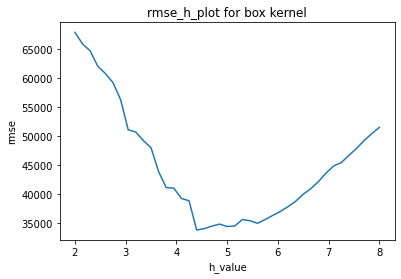

In [99]:
# You should open this file in colab to see the plots. 
# but if you do not use colab I will also plot my results with matplotlib library

from matplotlib import pyplot as plt

# rmse_h_plot for box kernel
dev_x=np.array(box_RMSE_list)[:,0] 
dev_y=np.array(box_RMSE_list)[:,1]

plt.plot(dev_x, dev_y)
plt.xlabel('h_value')
plt.ylabel('rmse')
plt.title('rmse_h_plot for box kernel')
plt.show()

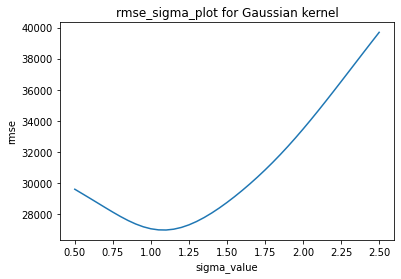

In [100]:
# rmse_sigma_plot for Gaussian kernel
dev_x=np.array(RMSE_list)[:,0] 
dev_y=np.array(RMSE_list)[:,1]

plt.plot(dev_x, dev_y)
plt.xlabel('sigma_value')
plt.ylabel('rmse')
plt.title('rmse_sigma_plot for Gaussian kernel')
plt.show()

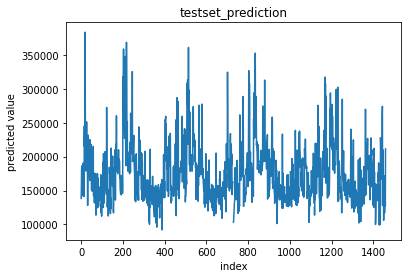

In [101]:
# predict the test set
dev_x=np.array(testset_prediction)[:,0] 
dev_y=np.array(testset_prediction)[:,1]

plt.plot(dev_x, dev_y)
plt.xlabel('index')
plt.ylabel('predicted value')
plt.title('testset_prediction')
plt.show()